# Лабораторная работа 3.
## Нейронные сети
В данной лабораторной работе рассматривается решение задачи классификации посредством многослойных полносвязных нейронных сетей прямого распространения.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (20,10)

(2399,)
(2399, 2) (2399,)


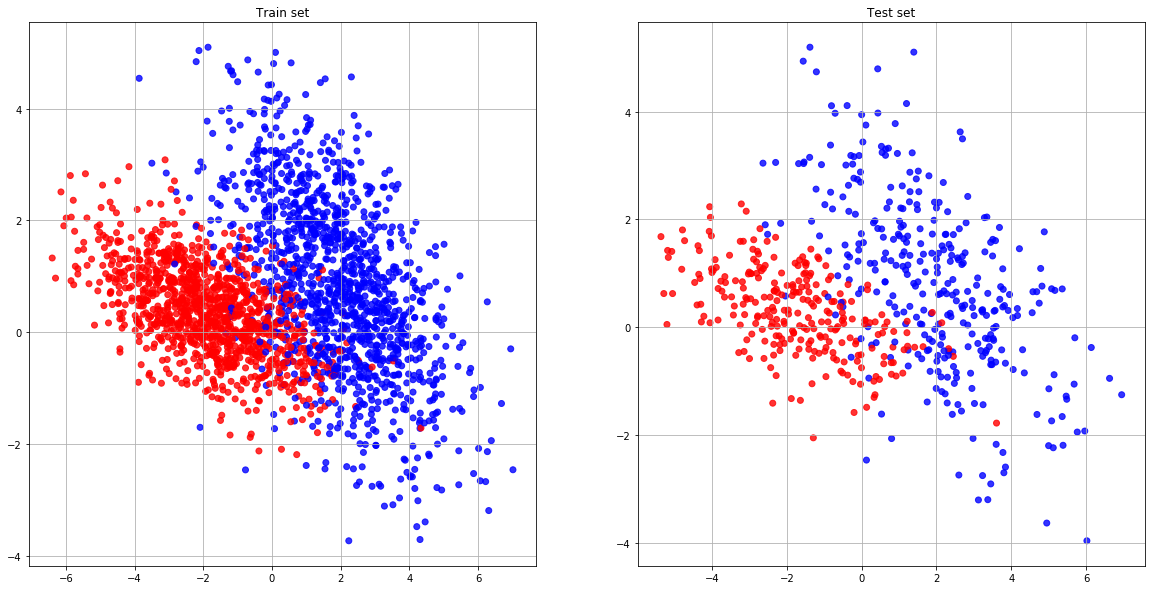

In [40]:
df = pd.read_csv('../lab2/2_features/9.csv')
X = df.iloc[:, 0:2].to_numpy()
y = df.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.shape)

color_map = {0: 'red', 1: 'blue'}

_, (axs0, axs1) = plt.subplots(1, 2)
axs0.scatter(X_train[:, 0], X_train[:, 1], c=np.vectorize(color_map.get)(y_train), alpha=0.8);
axs0.set_title('Train set')
axs0.grid()

axs1.scatter(X_test[:, 0], X_test[:, 1], c=np.vectorize(color_map.get)(y_test), alpha=0.8);
axs1.set_title('Test set')
axs1.grid()

print(X_train.shape, y_train.shape)

In [3]:
def logsig(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    tmp = x - x.max(axis=1)[:, np.newaxis]
    x = np.exp(tmp)
    x /= x.sum(axis=1)[:, np.newaxis]
    return x

ACTIVATIONS_MAP = {
    'logsig': logsig,
    'tanh': np.tanh,
    'relu': relu,
    'softmax': softmax
}


def logsig_deriv(z):
    return z * (1 - z)

def tanh_deriv(z):
    return 1 - z * z

def relu_deriv(z):
    return (z >= 0) * 1

DERIVATIVES_MAP = {
    'logsig': logsig_deriv,
    'tanh': tanh_deriv,
    'relu': relu_deriv
}


from scipy.special import xlogy

def squared_loss(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / 2

def cross_entropy_loss(y_true, y_pred):
#     print(y_pred)
    return -xlogy(y_true, y_pred).sum()

LOSS_MAP = {
    'squared': squared_loss,
    'cross_entropy': cross_entropy_loss
}


def batch_split(X, y, batch_size):
    data_size = y.shape[0]
    if batch_size == -1:
        batch_size = data_size
    
    packs_cnt = int(data_size / batch_size) + 1
    X_batchs = np.array_split(X, packs_cnt)
    y_batchs = np.array_split(y, packs_cnt)
    return X_batchs, y_batchs

## Реализация классификатора с помощью многослойной нейронной сети

In [8]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import OneHotEncoder

class NNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_sizes=(50,), dropout_prob=None, hidden_activation='relu', out_activation='softmax',
                 l_rate=1e-1, epocs=10, batch_size=-1, random_base=1, verbose=False, history=False):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.dropout_prob = dropout_prob
        self.hidden_activation = hidden_activation
        self.out_activation = out_activation
        self.l_rate = l_rate
        self.epocs = epocs
        self.batch_size = batch_size
        self.random_base = random_base
        self.verbose = verbose
        self.history = history

    def _init_weight(self, in_features, out_features):
        d = np.sqrt(3 / (in_features + 1))
        weights = np.random.RandomState(self.random_base).uniform(-d, d, (in_features, out_features))
        biases = np.random.RandomState(self.random_base).uniform(-d, d, out_features)
        return weights, biases    


    def _init_params(self, X, y):
        hidden_layer_sizes = list(self.hidden_layer_sizes)
        # output count
        self.n_out_ = y.shape[1]
        # layer sizes
        self.net_sizes_ = [X.shape[1]] + hidden_layer_sizes + [self.n_out_]
        # layer amount
        self.net_len_ = len(self.net_sizes_)
        
        self.weights_ = []
        self.biases_ = []
        
        for i in range(self.net_len_ - 1):
            weights, biases = self._init_weight(self.net_sizes_[i], self.net_sizes_[i + 1])
            self.weights_.append(weights)
            self.biases_.append(biases)
            
        # init loss function
        if self.out_activation == 'logsig':
            self.loss_func_ = LOSS_MAP['squared']
        else:
            self.loss_func_ = LOSS_MAP['cross_entropy']


    def _forward_pass(self, activations, weights, biases, is_training=False):
        hidden_activation = ACTIVATIONS_MAP[self.hidden_activation]

        last_ind = self.net_len_ - 1
        
        for i in range(last_ind):
            activations[i + 1] = np.dot(activations[i], weights[i])
            activations[i + 1] += biases[i]
            
            # hidden layers
            if (i + 1) != (last_ind):
                activations[i + 1] = hidden_activation(activations[i + 1])
            
            # last hidden layer
            if (i + 1) == (last_ind - 1):
                if is_training and (self.dropout_prob is not None):
                    q = 1 - self.dropout_prob
                    self.dropout_mask_ = np.random.binomial(1, q, activations[i + 1].shape) / q
                    activations[i + 1] *= self.dropout_mask_

        # output layers
        out_activation = ACTIVATIONS_MAP[self.out_activation]
        activations[i + 1] = out_activation(activations[i + 1])

        return activations

    def _compute_grad(self, layer, n_samples, activations, deltas, weights_grads, biases_grads):
        weights_grads[layer] = np.dot(activations[layer].T, deltas[layer]) / n_samples
        biases_grads[layer] = np.mean(deltas[layer], 0)

        return weights_grads, biases_grads

    def _backprop(self, X, y, activations, deltas, weights_grads, biases_grads):
        n_samples = X.shape[0]
        loss_val = self.loss_func_(y, activations[-1])

        last_n = self.net_len_ - 2
        deltas[last_n] = activations[-1] - y

        if (self.out_activation == 'logsig'):
            out_deriv = DERIVATIVES_MAP[self.out_activation]
            deltas[last_n] *= out_deriv(activations[-1])

        weights_grads, biases_grads = self._compute_grad(last_n, n_samples, activations, deltas, weights_grads,
                                                         biases_grads)

        for i in range(self.net_len_ - 2, 0, -1):
            deltas[i - 1] = np.dot(deltas[i], self.weights_[i].T)
            deriv_fun = DERIVATIVES_MAP[self.hidden_activation]            
            deltas[i - 1] *= deriv_fun(activations[i])
            if (i - 1) == (last_n - 2):
                    deltas[i - 1] *= self.dropout_mask_
                    activations[i - 1] *= self.dropout_mask_

            weights_grads, biases_grads = self._compute_grad(i - 1, n_samples, activations, deltas, weights_grads,
                                                             biases_grads)

        return loss_val, weights_grads, biases_grads       


    def fit(self, X, y):
        X, y = check_X_y(X, y, multi_output=True)
        check_classification_targets(y)

        if y.ndim == 1:
            y = y.reshape((-1, 1))
            
        self.label_binarizer_ = OneHotEncoder(handle_unknown='ignore')

        self.label_binarizer_.fit(y)
        y = self.label_binarizer_.transform(y).toarray()
        self._init_params(X, y)

        X_batchs, y_batchs = batch_split(X, y, self.batch_size)
        batch_cnt = len(y_batchs)
        eps = 1e-4
        
        activations = [X] + [None] * (self.net_len_ - 1)
        deltas = [None] * (len(activations) - 1)
        
        weights_grads = [np.empty((self.net_sizes_[i], self.net_sizes_[i + 1])) for i in range(self.net_len_ - 1)]
        biases_grads = [np.empty(self.net_sizes_[i + 1]) for i in range(self.net_len_ - 1)]
        self.params_history_ = []
        self.loss_curve_ = []
        self.dropout_mask_ = None

        for p_ in range(self.epocs):
            sum_loss = 0.0
            for i in range(batch_cnt):
                activations[0] = X_batchs[i]
                activations = self._forward_pass(activations, self.weights_, self.biases_, is_training=True)
                
                loss, weights_grads, biases_grads = self._backprop(X_batchs[i], y_batchs[i], activations,
                                                                   deltas, weights_grads, biases_grads)
                sum_loss += loss

                self.weights_ = [w - self.l_rate * grad for w, grad in zip(self.weights_, weights_grads)]
                self.biases_ = [b - self.l_rate * grad for b, grad in zip(self.biases_, biases_grads)]       

            sum_loss /= X.shape[0]
            self.loss_curve_.append(sum_loss)
            if self.history:
                self.params_history_.append((self.weights_, self.biases_))

            if self.verbose:
                print(f'Epoc: {p_}, loss: {sum_loss}')

        return self

    def predict(self, X, weights=None, biases=None):
        if weights is None:
            weights = self.weights_
        
        if biases is None:
            biases = self.biases_

        check_is_fitted(self, [])
        X = check_array(X)

        activations = [X]
        for i in range(self.net_len_ - 1):
            activations.append(np.empty((X.shape[0], self.net_sizes_[i + 1])))

        # forward propagate
        self._forward_pass(activations, weights, biases)
        y_pred = activations[-1]
        
        if self.n_out_ == 1:
            y_pred = y_pred.ravel()

        return self.label_binarizer_.inverse_transform(y_pred)
    
    def score(self, X, y, weights=None, biases=None):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X, weights, biases))
    
    def accuracy_curve(self, X, y):
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        y = self.label_binarizer_.transform(y).toarray()
        accuracy = []

        for w, b in self.params_history_:
            y_trans = self.label_binarizer_.inverse_transform(y)
            accuracy.append(self.score(X, y_trans, w, b))

        return accuracy

In [18]:
def plot_stat(hidden_activation, N_epocs=200):
    def _help_plot(axes, hidden, output):
        b_clf = lambda x: NNClassifier(hidden_layer_sizes=(x,), batch_size=100,  epocs=N_epocs, random_base=1,
                                       hidden_activation=hidden, out_activation=output, l_rate=0.1, history=True)
        clfs = [b_clf(i) for i in [2, 8, 16]]
        accs = dict()
        for clf in clfs:
            hn_size = clf.hidden_layer_sizes[0]
            clf.fit(X_train, y_train)
            axes[0].plot(clf.loss_curve_, label=f'hidden neurons= {hn_size}')
            axes[0].grid()
            axes[0].set_xlabel('epocs')
            axes[0].set_ylabel('Error')
            axes[0].set_title(f'Error: {hidden_activation} + {output}')
            axes[0].legend()
            
            accuracy_curve = clf.accuracy_curve(X_test, y_test)
            axes[1].plot(accuracy_curve, label=f'hidden neurons = {hn_size}')
            axes[1].grid()
            axes[1].set_xlabel('epocs')
            axes[1].set_ylabel('Accuracy')
            axes[1].set_title(f'Test accuracy: {hidden_activation} + {output}')
            axes[1].legend()
            
            accs[hn_size] = accuracy_curve[-1]
        
        best_hn = max(accs, key=accs.get)            
        print(f'Best accuracy for {hidden} + {output}, hidden neurons = {best_hn}: {accs[best_hn]:.3f}')


    _, axs = plt.subplots(2, 2)
    _help_plot(axs[0], hidden_activation, 'logsig')
    _help_plot(axs[1], hidden_activation, 'softmax')


Для классификации набора даных из прошлой ЛР построим трёх слойную нейронную сеть.
Проведем эксперименты, рассматривая разные комбинации активационной функции для внутреннего слоя и для выходного.
Также будем будем менять количество нейронов внутреннего слоя.

Best accuracy for relu + logsig, hidden neurons = 16: 0.940
Best accuracy for relu + softmax, hidden neurons = 16: 0.943


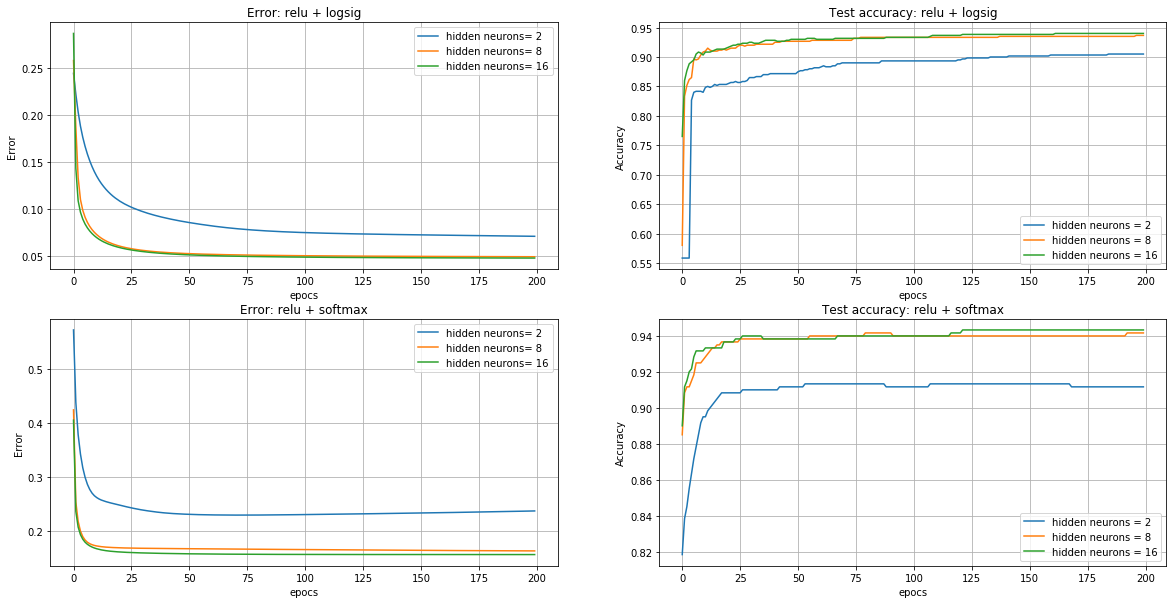

In [19]:
plot_stat('relu', N_epocs=200)

Best accuracy for logsig + logsig, hidden neurons = 2: 0.922
Best accuracy for logsig + softmax, hidden neurons = 8: 0.932


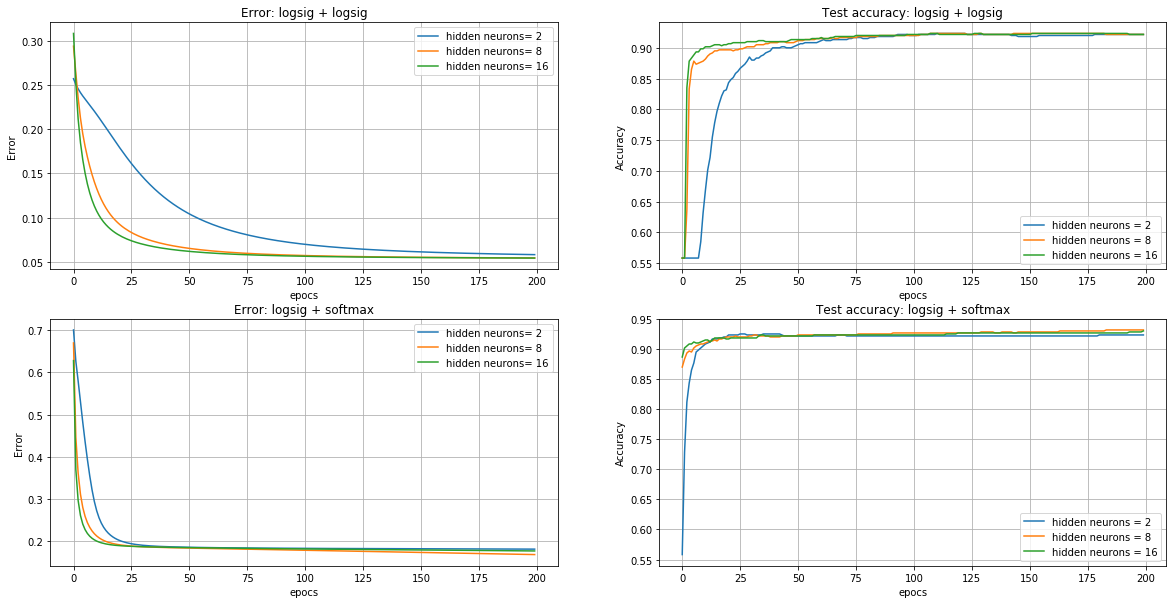

In [20]:
plot_stat('logsig', N_epocs=200)

Best accuracy for tanh + logsig, hidden neurons = 8: 0.937
Best accuracy for tanh + softmax, hidden neurons = 8: 0.940


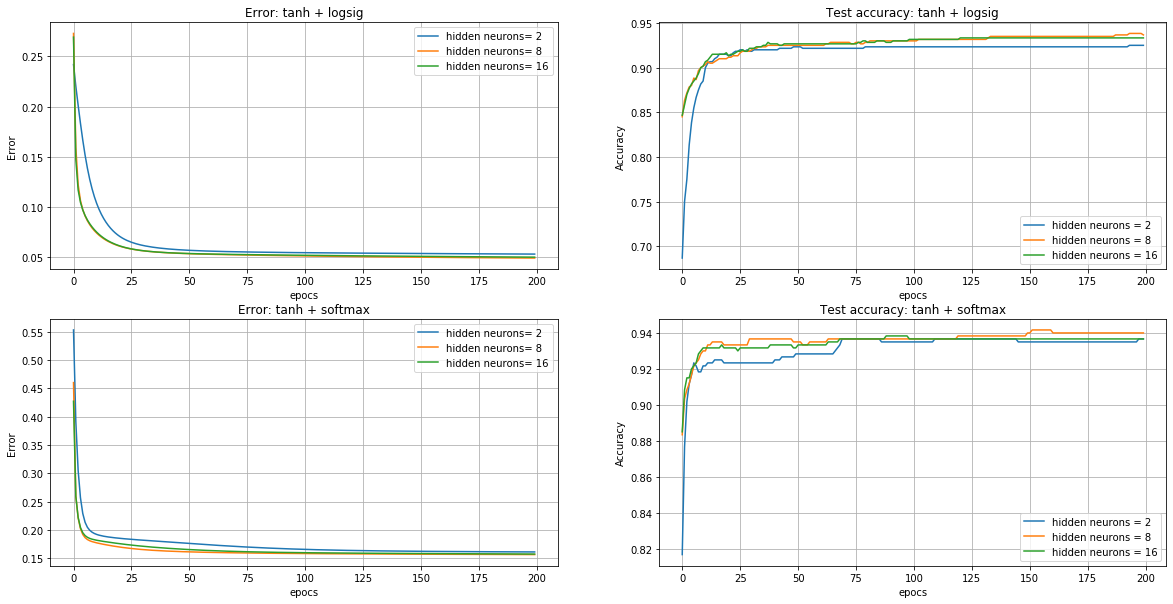

In [21]:
plot_stat('tanh', N_epocs=200)

## Вывод
Как видим, лучший результат точности на тестовом наборе $\approx 0.94$.
Лучше всего себя показал вариант с функцией `relu` на внутреннем слое, с 16 "внутренними" нейронами.
Затем идёт вариант с `tanh` с 8 "внутренними" нейронами.
Логистическая сигмоида на внутреннем слое немного отстает.

В ЛР2 максимальная точность была $\approx 0.925$. Видим, что классификация с помощью нейронной сети помогает улучшить точность(даже без применения регуляризации и метода `momentum`).

## Multiclass classification
Теперь рассмотрим многоклассовую классификацию.
Предлагается классифицировать изображения, на которых изображены английские буквы.

In [22]:
from skimage.io import imread
import os

X_mnist = []
y_mnist = []

for root, dirs, files in os.walk('../lab3/notMNIST/'):
    for im in files:
        label = os.path.dirname(os.path.join(root, im))[-1]
        image = imread(os.path.join(root, im))
        X_mnist.append(image)
        y_mnist.append(label)

num_samples = len(X_mnist)
print('Number of images: ', num_samples)

Number of images:  18724


Train set:  (14979, 784) (14979,)
Test set:  (3745, 784) (3745,)


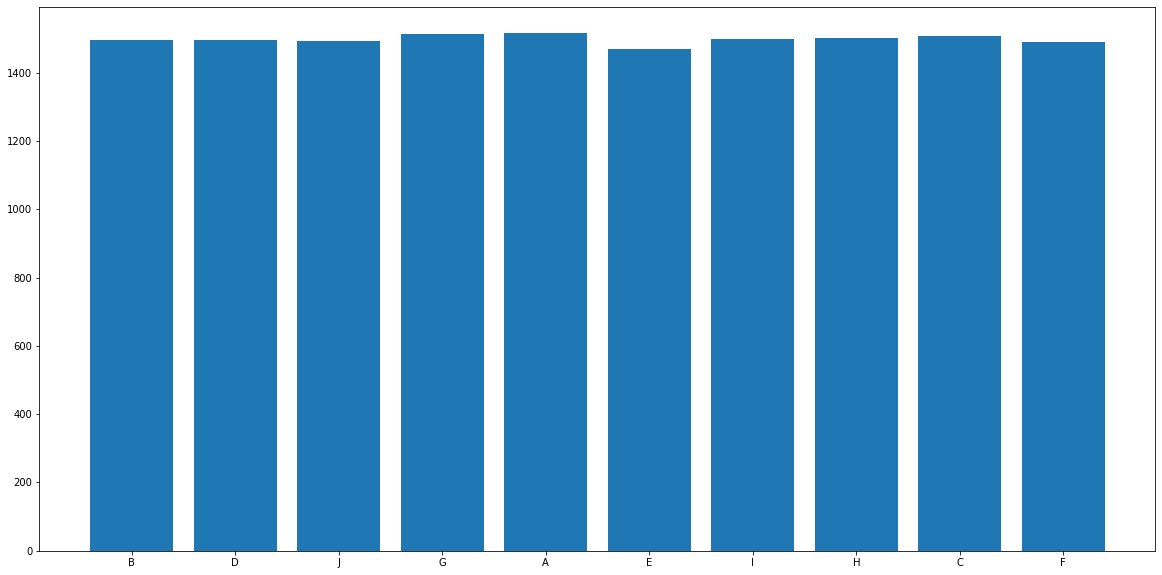

In [24]:
X = np.asarray(X_mnist, dtype=np.float).reshape((num_samples, -1))
y = np.asarray(y_mnist)

X /= 255

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

from collections import Counter

cntr = Counter()
for label in y_train:
    cntr[label] += 1
    
plt.bar(cntr.keys(), cntr.values());

Предлагалось взять 4096 нейронов на внутреннем слое. Но из-за этого неудобно проводить эксперименты.
Поэтому я уменьшил количество нейронов в 4 раза и оказалось, что переобучение также присутствует, точность не меняется.

Далее рассматриваю 1028 нейронов на внутреннем слое.

Подберем параметр $\alpha$ скорости градиентного спуска с помощью кросс-валидации.

In [25]:
from sklearn.model_selection import GridSearchCV

def get_best_model(estimator, param_grid):

    grid_model = GridSearchCV(estimator, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_

    print(f'Best params: {grid_model.best_params_}')
    print(f'Train accuracy: {best_model.score(X_train, y_train)}')
    print(f'Test accuracy: {best_model.score(X_test, y_test)}')
    
    return best_model

In [26]:
params = {
    'l_rate': np.geomspace(1e-1, 1, 5),    
}

mlp_model = NNClassifier(hidden_layer_sizes=(1028,), epocs=10, verbose=False, random_base=1, batch_size=200,
                   hidden_activation='relu', out_activation='softmax')
l_rate_best_model = get_best_model(mlp_model, params)

Best params: {'l_rate': 0.1}
Train accuracy: 0.9111422658388411
Test accuracy: 0.8945260347129506


In [33]:
def plot_accuracy(clf, ax, X, y, set_name):
    accuracy_curve = clf.accuracy_curve(X, y)
    ax.plot(accuracy_curve)
    ax.grid()
    ax.set_xlabel('epocs')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{set_name} accuracy')

## Без dropout

Epoc: 0, loss: 0.7881015986660812
Epoc: 1, loss: 0.45840647370659093
Epoc: 2, loss: 0.4170936826240416
Epoc: 3, loss: 0.39472934387510494
Epoc: 4, loss: 0.3791511493532424
Epoc: 5, loss: 0.36705816561977095
Epoc: 6, loss: 0.3570774127156649
Epoc: 7, loss: 0.3485275448882459
Epoc: 8, loss: 0.34100672480155386
Epoc: 9, loss: 0.3342640525415509
Epoc: 10, loss: 0.3281453297723149
Epoc: 11, loss: 0.3225408263044669
Epoc: 12, loss: 0.31735742176010223
Epoc: 13, loss: 0.3125333068727453
Epoc: 14, loss: 0.30802267959657365
Epoc: 15, loss: 0.30379453654073835
Epoc: 16, loss: 0.29981201620885173
Epoc: 17, loss: 0.29604422810173153
Epoc: 18, loss: 0.2924691458838771
Epoc: 19, loss: 0.2890763480744401
Epoc: 20, loss: 0.2858486892252915
Epoc: 21, loss: 0.28277261468968384
Epoc: 22, loss: 0.27983880734945177
Epoc: 23, loss: 0.2770417456629831
Epoc: 24, loss: 0.27436776025436443
Epoc: 25, loss: 0.2718140275924119
Epoc: 26, loss: 0.26937121848396534
Epoc: 27, loss: 0.26702686063750924
Epoc: 28, loss: 

Epoc: 227, loss: 0.14968888033459185
Epoc: 228, loss: 0.149463250855439
Epoc: 229, loss: 0.149241216504901
Epoc: 230, loss: 0.14902049784817814
Epoc: 231, loss: 0.1487985516875431
Epoc: 232, loss: 0.14857572821423312
Epoc: 233, loss: 0.14835320764096055
Epoc: 234, loss: 0.1481304847955016
Epoc: 235, loss: 0.1479083084394497
Epoc: 236, loss: 0.14768509108099362
Epoc: 237, loss: 0.14746277232711505
Epoc: 238, loss: 0.1472411221357854
Epoc: 239, loss: 0.14702061631954727
Epoc: 240, loss: 0.1468012351432853
Epoc: 241, loss: 0.1465825786495544
Epoc: 242, loss: 0.1463647376523381
Epoc: 243, loss: 0.14614940990909694
Epoc: 244, loss: 0.14593545832670798
Epoc: 245, loss: 0.14572231936024563
Epoc: 246, loss: 0.14550893246344543
Epoc: 247, loss: 0.14529532247150864
Epoc: 248, loss: 0.14508238176410002
Epoc: 249, loss: 0.1448685752717342
Epoc: 250, loss: 0.14465651519744152
Epoc: 251, loss: 0.1444472242515255
Epoc: 252, loss: 0.1442381591690236
Epoc: 253, loss: 0.14402915540590938
Epoc: 254, loss

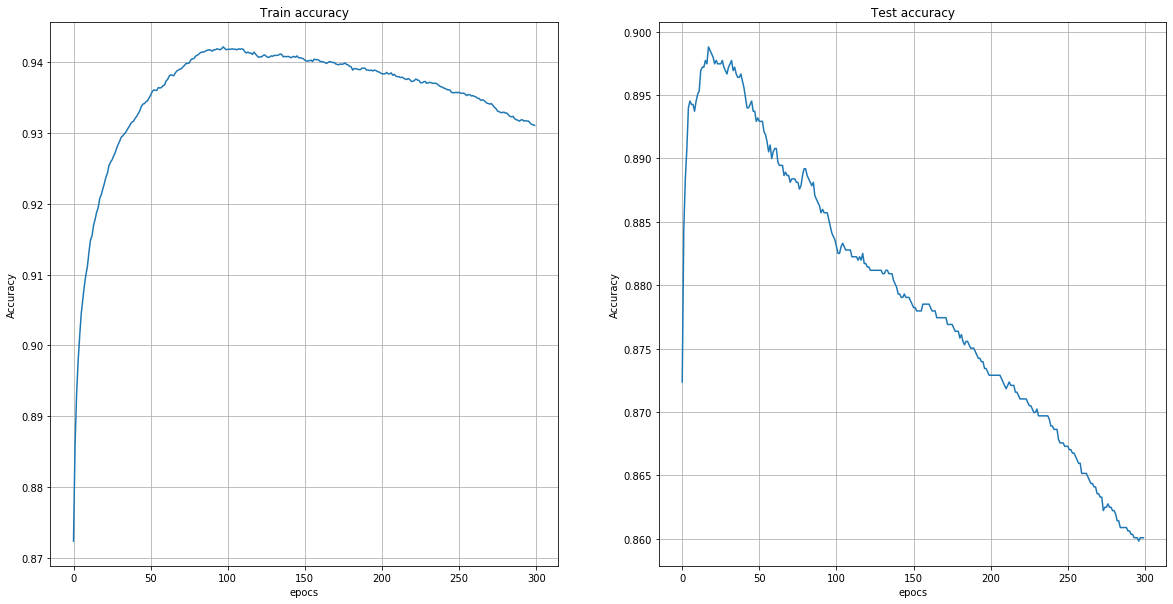

In [37]:
mlp = NNClassifier(hidden_layer_sizes=(1028,), epocs=300, verbose=True, random_base=1, batch_size=200,
                   hidden_activation='relu', out_activation='softmax', l_rate=.1, history=True,
                   dropout_prob=None)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

_, (ax0, ax1) = plt.subplots(1, 2)
plot_accuracy(mlp, ax0, X_train, y_train, 'Train')
plot_accuracy(mlp, ax1, X_test, y_test, 'Test')

## С dropout

Epoc: 0, loss: 0.8367754035290451
Epoc: 1, loss: 0.4918515497647417
Epoc: 2, loss: 0.4506067586633988
Epoc: 3, loss: 0.4280291575387024
Epoc: 4, loss: 0.4056097325640562
Epoc: 5, loss: 0.3938953407693604
Epoc: 6, loss: 0.3890036615809281
Epoc: 7, loss: 0.3800458099980004
Epoc: 8, loss: 0.3680789067031693
Epoc: 9, loss: 0.3636735116724719
Epoc: 10, loss: 0.35723540371980167
Epoc: 11, loss: 0.3509001288019929
Epoc: 12, loss: 0.3498045174468321
Epoc: 13, loss: 0.34504606816138794
Epoc: 14, loss: 0.33902809207742696
Epoc: 15, loss: 0.3324823971942058
Epoc: 16, loss: 0.33214890882586223
Epoc: 17, loss: 0.32684392159784786
Epoc: 18, loss: 0.3243401981439834
Epoc: 19, loss: 0.31786890717249394
Epoc: 20, loss: 0.31548632516755526
Epoc: 21, loss: 0.31694694673837115
Epoc: 22, loss: 0.3123565778514849
Epoc: 23, loss: 0.30868097213267487
Epoc: 24, loss: 0.3081038220263973
Epoc: 25, loss: 0.305760337112549
Epoc: 26, loss: 0.30259853570731454
Epoc: 27, loss: 0.3021604836742236
Epoc: 28, loss: 0.298

Epoc: 228, loss: 0.23303499323572885
Epoc: 229, loss: 0.23154766269432445
Epoc: 230, loss: 0.23080100922600774
Epoc: 231, loss: 0.23189768355456408
Epoc: 232, loss: 0.23181876630586956
Epoc: 233, loss: 0.23172779861760895
Epoc: 234, loss: 0.23200284321660491
Epoc: 235, loss: 0.23144862895848117
Epoc: 236, loss: 0.23526539091723214
Epoc: 237, loss: 0.2333740346333869
Epoc: 238, loss: 0.23542166599987702
Epoc: 239, loss: 0.234886375691971
Epoc: 240, loss: 0.2316111072771361
Epoc: 241, loss: 0.23670073135522998
Epoc: 242, loss: 0.23555277621143048
Epoc: 243, loss: 0.22957175017905262
Epoc: 244, loss: 0.2296478205925595
Epoc: 245, loss: 0.23159832480656958
Epoc: 246, loss: 0.2316669502694346
Epoc: 247, loss: 0.23245315804759212
Epoc: 248, loss: 0.22937240424204958
Epoc: 249, loss: 0.2350022622155608
Epoc: 250, loss: 0.23379741771031626
Epoc: 251, loss: 0.22971927156328573
Epoc: 252, loss: 0.22971132658016455
Epoc: 253, loss: 0.2318456614347098
Epoc: 254, loss: 0.23020329572500606
Epoc: 255

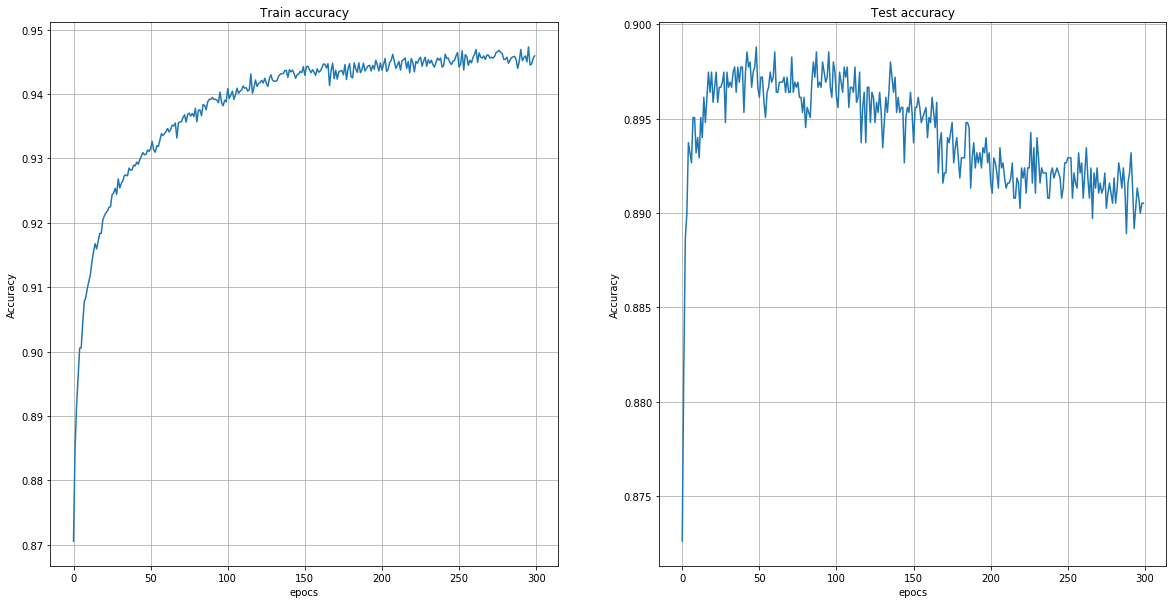

In [38]:
mlp = NNClassifier(hidden_layer_sizes=(1028,), epocs=300, verbose=True, random_base=1, batch_size=200,
                   hidden_activation='relu', out_activation='softmax', l_rate=.1, history=True,
                   dropout_prob=0.5)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

_, (ax0, ax1) = plt.subplots(1, 2)
plot_accuracy(mlp, ax0, X_train, y_train, 'Train')
plot_accuracy(mlp, ax1, X_test, y_test, 'Test')

Как видно, без `dropout` у модели после приблизительно 100 эпох начали ухудшаться точности.
Возможно, это не переобучение, а срыв градиента вблизи экстремума.

Но применим `dropout` с коэффициентов $p = 0.5$, т.е. удалив примерно 50% нейронов, удалось увеличить точности.
Точность на обучающих данных перестала ухудшаться, а на тестовой ухудшается не так сильно.
Но появились ощутимые скачки градиента(пилообразный характер графиков).

## Вывод
Техника `dropout` помогла улучшить точность на тестовых данных, но в данном случае переобучение немного осталось.
Возможно, мог бы помочь метод `momentum` и дополнительная регуляризация, добавлением дополнительного штрафа в функцию ошибки.